In [1]:
# Core
import numpy as np
import pandas as pd

# Tensorflow / ML
import tensorflow as tf
from tensorflow.python.keras import backend as K

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Utility
import time

# MSE Imports
import kepler_sieve
from asteroid_element import load_ast_elt
from candidate_element import asteroid_elts, perturb_elts, random_elts, elts_add_mixture_params
from ztf_ast import load_ztf_nearest_ast, calc_hit_freq
from ztf_element import load_ztf_batch, make_ztf_batch, ztf_score_by_elt, ztf_elt_summary
from asteroid_model import AsteroidPosition, AsteroidDirection, make_model_ast_pos
from asteroid_search_layers import CandidateElements, TrajectoryScore
from asteroid_search_model import AsteroidSearchModel, make_opt_adam
from asteroid_search_report import traj_diff
from candidate_element import score_by_elt
from astro_utils import deg2dist, dist2deg, dist2sec

Found 4 GPUs.  Setting memory growth = True.


In [2]:
# Aliases
keras = tf.keras

# Constants
dtype = tf.float32
dtype_np = np.float32
space_dims = 3

In [3]:
# Set plot style variables
mpl.rcParams['figure.figsize'] = [16.0, 10.0]
mpl.rcParams['font.size'] = 16

In [4]:
# Color for plots
color_mean = 'blue'
color_lo = 'orange'
color_hi = 'green'
color_min = 'red'
color_max = 'purple'

## Load ZTF Data and Batch of Orbital Elements

In [5]:
# Load orbital elements for known asteroids
ast_elt = load_ast_elt()

# Number of asteroids
N_ast = ast_elt.shape[0]

In [6]:
# Load ztf nearest asteroid data
ztf_ast = load_ztf_nearest_ast()

In [7]:
# Asteroid numbers and hit counts
ast_num, hit_count = calc_hit_freq(ztf=ztf_ast, thresh_sec=2.0)

# Sort the hit counts in descending order and find the top batch_size
idx = np.argsort(hit_count)[::-1]

# Extract the asteroid number and hit count for this batch
ast_num_best = ast_num[idx]
hit_count_best = hit_count[idx]

In [8]:
# Parameters to build elements batch
batch_size = 64

# Batch of unperturbed elements
elts_ast = asteroid_elts(ast_nums=ast_num_best[0:batch_size])

In [9]:
# # Review unperturbed elements
# elts_ast

In [10]:
# Inputs to perturb elements: large
sigma_a = 0.05
sigma_e = 0.01
sigma_inc_deg = 0.25
sigma_f_deg = 1.0
sigma_Omega_deg = 1.0
sigma_omega_deg = 1.0
mask_pert = None
random_seed = 42

# Perturb orbital elements
elts = perturb_elts(elts_ast, sigma_a=sigma_a, sigma_e=sigma_e, 
                    sigma_inc_deg=sigma_inc_deg, sigma_f_deg=sigma_f_deg, 
                    sigma_Omega_deg=sigma_Omega_deg, sigma_omega_deg=sigma_omega_deg,
                    mask_pert=mask_pert, random_seed=random_seed)

In [11]:
# Review perturbed elements
# elts_pert

## Batches of ZTF Data vs. Elements

In [12]:
# Arguments to make_ztf_batch
# thresh_deg = 1.0
thresh_deg = 2.0
# thresh_deg = 4.0
near_ast = False
regenerate = False

In [13]:
# Load perturbed element batch
ztf_elt = load_ztf_batch(elts=elts, thresh_deg=thresh_deg, near_ast=near_ast, regenerate=regenerate)

In [14]:
# Score by element - perturbed
score_by_elt = ztf_score_by_elt(ztf_elt)

In [15]:
# Summarize the ztf element batch: perturbed asteroids
ztf_elt_summary(ztf_elt, score_by_elt, 'Perturbed Asteroids')

ZTF Element Dataframe Perturbed Asteroids:
                  Total     (Per Batch)
Observations   :   290771   (     4543)

Summarize score = sum(-1.0 - log(v)) by batch.  (Mean=0, Variance=num_obs)
Mean score     :      42.77
Sqrt(batch_obs):      67.40
Mean t_score   :       0.58


In [16]:
# Mixture parameters
num_hits: int = 20
R_deg: float = 0.5

In [17]:
# Add mixture parameters to candidate elements
elts_add_mixture_params(elts=elts, score_by_elt=score_by_elt, num_hits=num_hits, R_deg=R_deg)

In [18]:
# Review perturbed elements
elts

,element_id,a,e,inc,Omega,omega,f,epoch,h,R
0,51921,2.736430,0.219134,0.499988,4.721815,2.452489,-1.129754,58600.0,0.004412,0.008727
1,59244,2.616575,0.266087,0.462848,5.725946,1.777382,-1.623105,58600.0,0.007027,0.008727
2,15786,1.945213,0.047621,0.385594,6.142435,0.790543,-1.243047,58600.0,0.006236,0.008727
3,3904,2.758664,0.099270,0.261841,5.463683,2.238942,-1.350620,58600.0,0.006647,0.008727
4,142999,2.589450,0.192070,0.509382,0.221844,0.928905,-1.314727,58600.0,0.005598,0.008727
...,...,...,...,...,...,...,...,...,...,...
59,11952,2.330603,0.084892,0.117649,0.042808,2.890716,-3.000560,58600.0,0.001981,0.008727
60,134815,2.550916,0.141660,0.510228,0.284591,0.630896,-0.920797,58600.0,0.007921,0.008727
61,27860,2.595202,0.098315,0.194023,5.535984,3.255585,3.966790,58600.0,0.003156,0.008727
62,85937,2.216242,0.195323,0.437115,5.285351,3.172956,3.921169,58600.0,0.007348,0.008727


## Train on Perturbed Elements: Learn Mixture Parameters

In [19]:
# Observatory for ZTF data is Palomar Mountain
site_name = 'palomar'

In [20]:
# Training parameters
learning_rate = 2.0**-12
clipnorm = 1.0
save_at_end: bool = True

In [21]:
# Build asteroid search model
model = AsteroidSearchModel(
                elts=elts, ztf_elt=ztf_elt, 
                site_name=site_name, thresh_deg=thresh_deg, 
                learning_rate=learning_rate, clipnorm=clipnorm,
                name='model_pert')

In [23]:
# Report before training starts
model.report()

     \  log_like :  hits  :  R_deg    :    R_sec
Mean :   292.73  :  20.90 :  0.691056 :  2487.80
Std  :   523.09  :  55.12 :  0.349650 :  1258.74
Min  :     9.47  :   0.00 :  0.000382 :     1.37
Max  :  1974.19  : 188.99 :  1.000000 :  3600.00


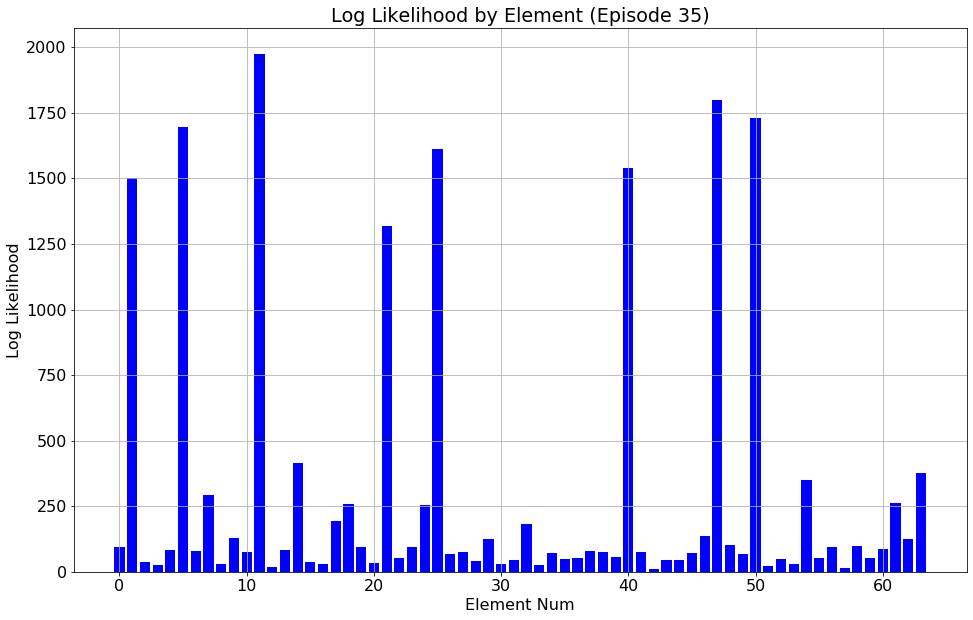

In [24]:
# Visualize log likelihood before traning
fig, ax = model.plot_bar('log_like', sorted=False)

In [25]:
# Adaptive search parameters
max_batches_mixture = 10000
max_batches_element = 20000
batches_per_epoch = 100
epochs_per_episode = 5
max_bad_episodes = 3
min_learning_rate = None
save_at_end = True
verbose = 1

In [26]:
# Load model
model.load()

In [27]:
model.report()

     \  log_like :  hits  :  R_deg    :    R_sec
Mean :   292.73  :  20.90 :  0.691056 :  2487.80
Std  :   523.09  :  55.12 :  0.349650 :  1258.74
Min  :     9.47  :   0.00 :  0.000382 :     1.37
Max  :  1974.18  : 188.99 :  1.000000 :  3600.00


In [28]:
# Preliminary round of training with frozen elements
model.freeze_candidate_elements()

In [29]:
# Train perturbed model with frozen orbital elements
model.search_adaptive(
    max_batches=max_batches_mixture, 
    batches_per_epoch=batches_per_epoch,
    epochs_per_episode=epochs_per_episode,
    min_learning_rate=min_learning_rate,
    save_at_end=True,
    verbose=verbose)


********************************************************************************
Terminating: Completed 10900 batches.
********************************************************************************
Saving candidate elements DataFrame in ../data/candidate_elt/candidate_elt_7003121184606232928.h5.


In [30]:
# Report after initial training on mixture parameters
model.report()

     \  log_like :  hits  :  R_deg    :    R_sec
Mean :   292.73  :  20.90 :  0.691056 :  2487.80
Std  :   523.09  :  55.12 :  0.349650 :  1258.74
Min  :     9.47  :   0.00 :  0.000382 :     1.37
Max  :  1974.18  : 188.99 :  1.000000 :  3600.00


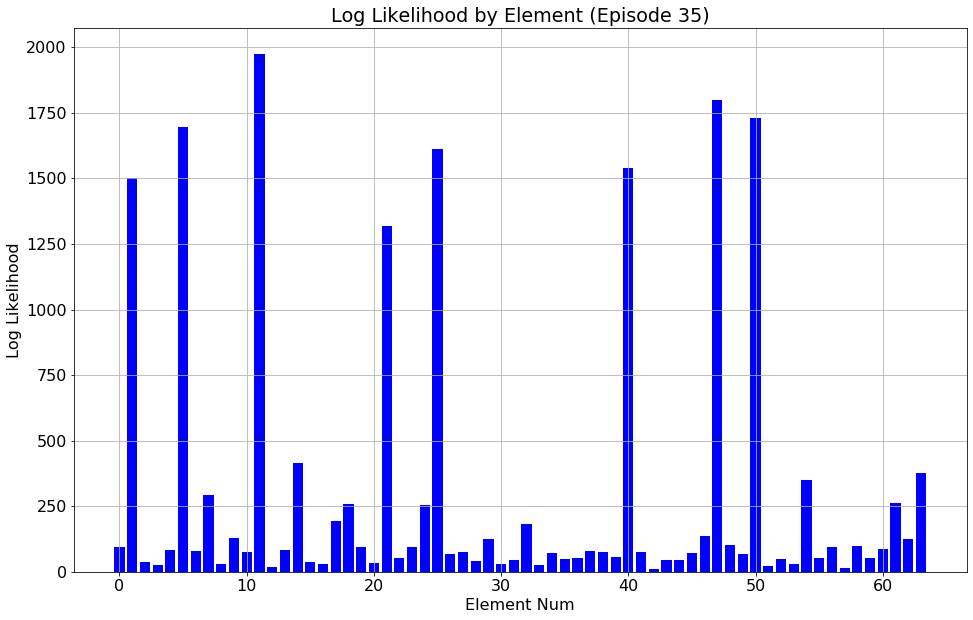

In [31]:
# Bar chart - log likelihood by element
fig, ax = model.plot_bar('log_like', sorted=False)

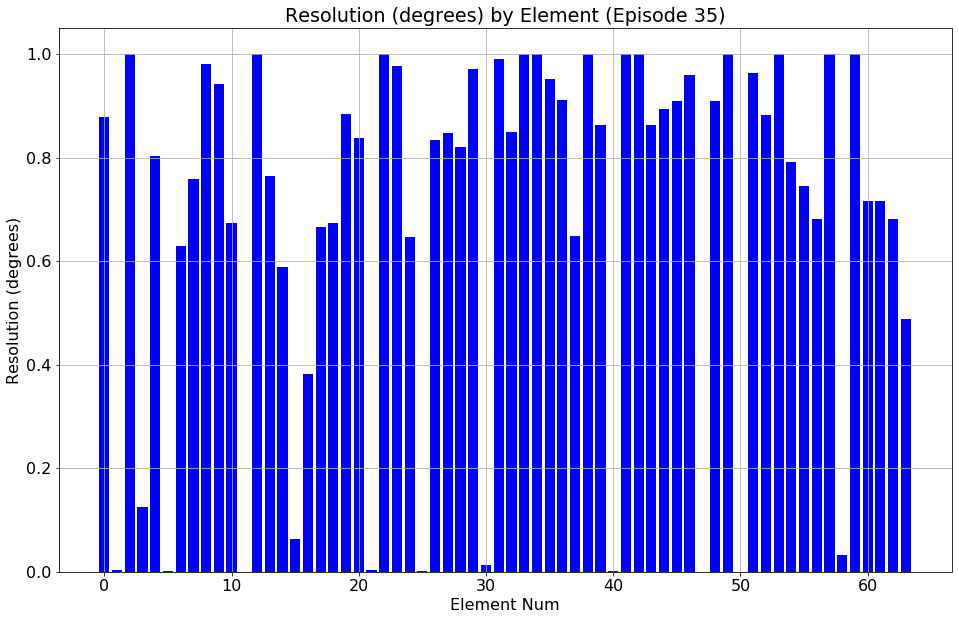

In [32]:
# Bar chart - log likelihood by element
fig, ax = model.plot_bar('R_deg', sorted=False)

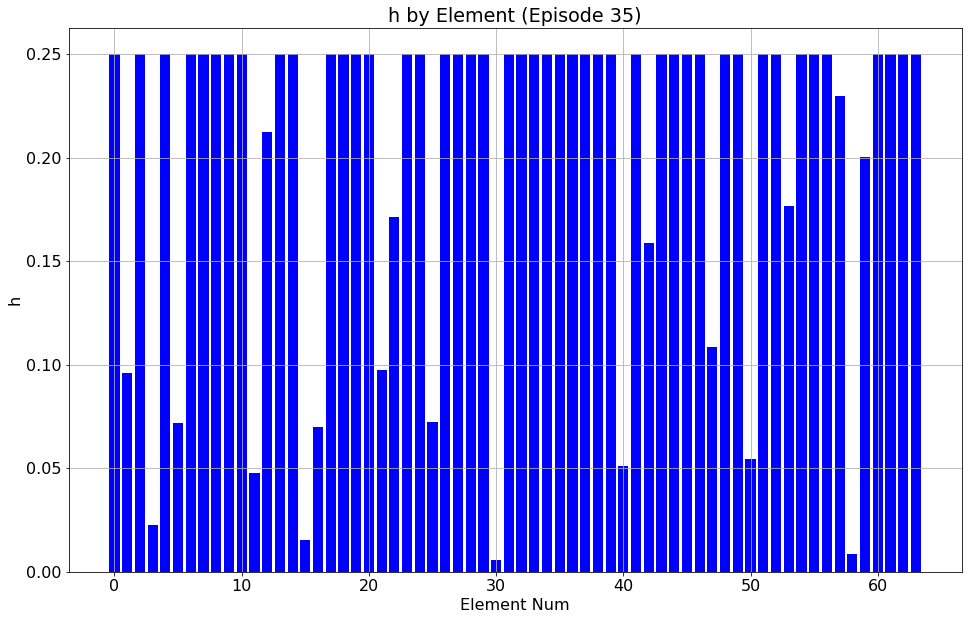

In [33]:
# Bar chart - log likelihood by element
fig, ax = model.plot_bar('h', sorted=False)

## Train on Perturbed Model: Joint (Elements & Mixture)

In [34]:
# # Load model with trained mixture weights 
# model.load()

In [35]:
# Unfreeze the elements, freeze the mixture model parameters
model.thaw_candidate_elements()

In [36]:
# New smaller learning rate
learning_rate = 2.0**-14

In [37]:
# Train unperturbed model with frozen orbital elements
model.search_adaptive(
    max_batches=max_batches_element, 
    batches_per_epoch=batches_per_epoch,
    epochs_per_episode=epochs_per_episode,
    learning_rate=learning_rate,
    min_learning_rate=min_learning_rate,
    save_at_end=False,
    verbose=verbose)


Training episode 35: Epoch  109, Batch  10900
effective_learning_rate=2.441e-04, training_time 1190 sec.
Train on 6400 samples
Epoch 110/114
6400/6400 [==============================] - 5s 739us/sample - loss: -4672.7574
Epoch 111/114
6400/6400 [==============================] - 2s 364us/sample - loss: -4739.9795
Epoch 112/114
6400/6400 [==============================] - 2s 376us/sample - loss: -4858.2689
Epoch 113/114
6400/6400 [==============================] - 2s 368us/sample - loss: -4894.6846
Epoch 114/114
6400/6400 [==============================] - 2s 372us/sample - loss: -4932.4225
Adjusted element weight down on 58 candidate elements. Mean weight = 5.47e-01
Geom Mean Resolution: 0.296418 degrees (1067.1 arc seconds)
Mean Hits          :     20.90
Mean Log Likelihood:    292.78

Training episode 36: Epoch  114, Batch  11400
effective_learning_rate=3.338e-05, training_time 1275 sec.
Train on 6400 samples
Epoch 115/119
6400/6400 [==============================] - 2s 380us/sample

In [38]:
# Report after training
model.report()

     \  log_like :  hits  :  R_deg    :    R_sec
Mean :   296.69  :  21.32 :  0.683453 :  2460.43
Std  :   526.25  :  55.05 :  0.356815 :  1284.53
Min  :    15.76  :   0.00 :  0.000382 :     1.37
Max  :  1974.19  : 188.99 :  1.000000 :  3600.00


In [ ]:
model.save_state()

In [ ]:
# Bar chart - log likelihood by element
fig, ax = model.plot_bar('log_like', sorted=True)

## Train Mixture Parameters Only

In [ ]:
# Freeze the orbital elements
model.freeze_candidate_elements()

In [ ]:
model.training_mode

In [ ]:
model.get_active_weight()

In [ ]:
model.current_batch

In [ ]:
# Train unperturbed model with frozen orbital elements
model.search_adaptive(
    max_batches=15000, 
    batches_per_epoch=batches_per_epoch,
    epochs_per_episode=epochs_per_episode,
    learning_rate=learning_rate,
    min_learning_rate=min_learning_rate,
    save_at_end=False,
    verbose=verbose)

In [ ]:
model.save_state()

## Review Results Graphically

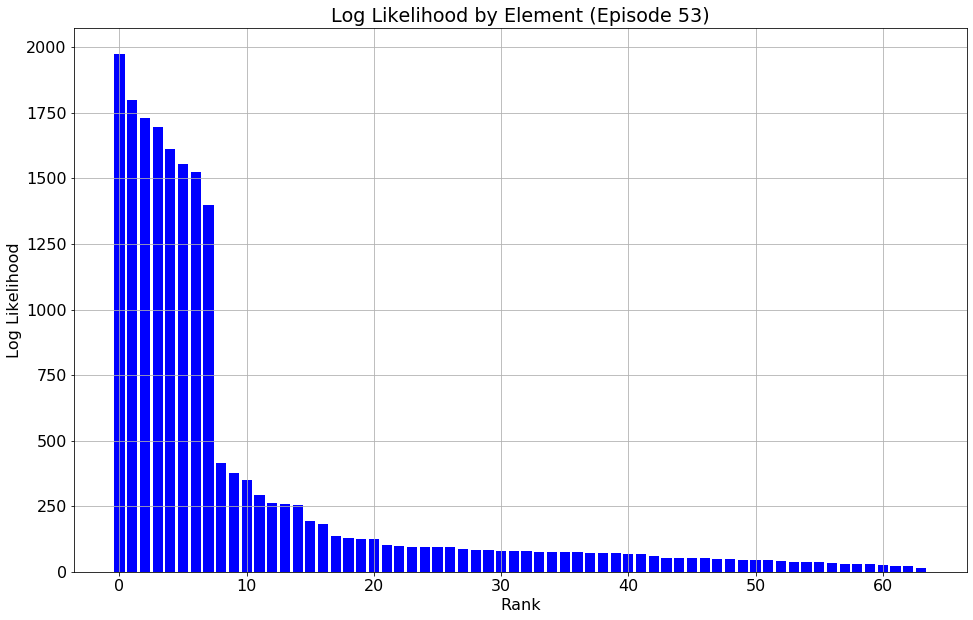

In [39]:
# Bar chart - log likelihood by element
fig, ax = model.plot_bar('log_like', sorted=True)

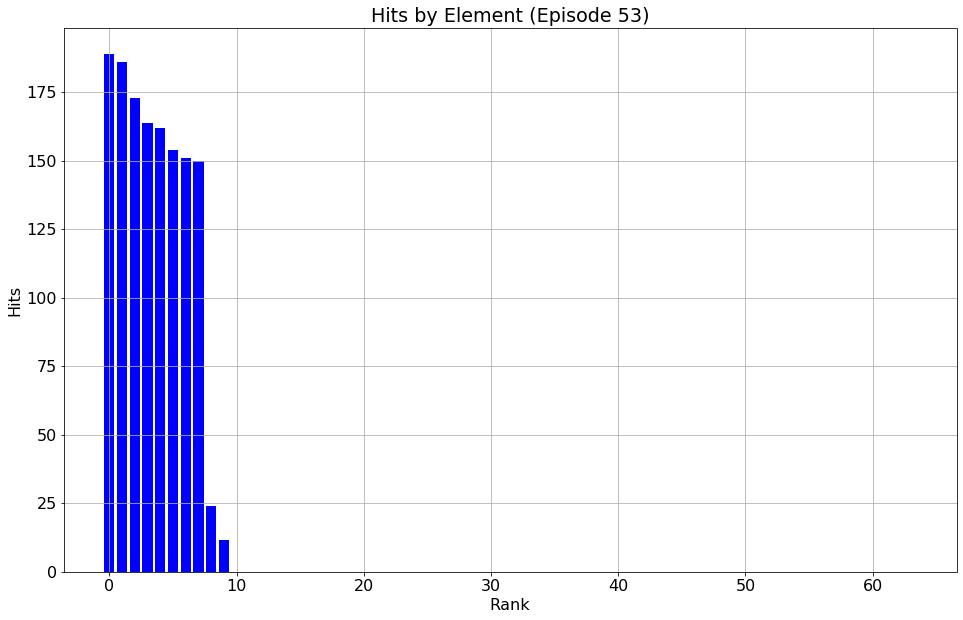

In [40]:
# Bar chart: hits
fig, ax = model.plot_bar('hits')

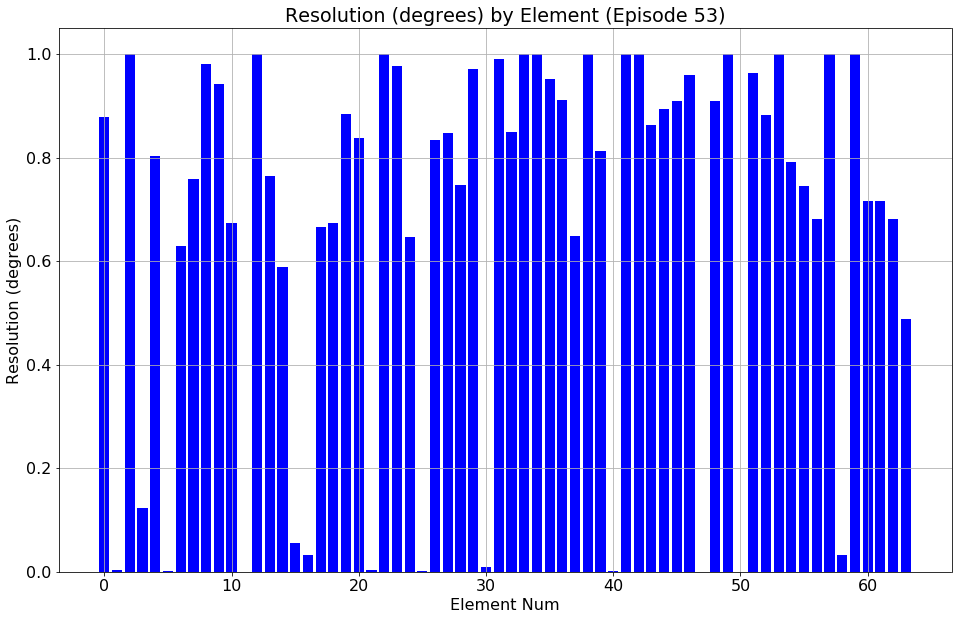

In [41]:
# Bar chart: log likelihood
fig, ax = model.plot_bar('R_deg', sorted=False)

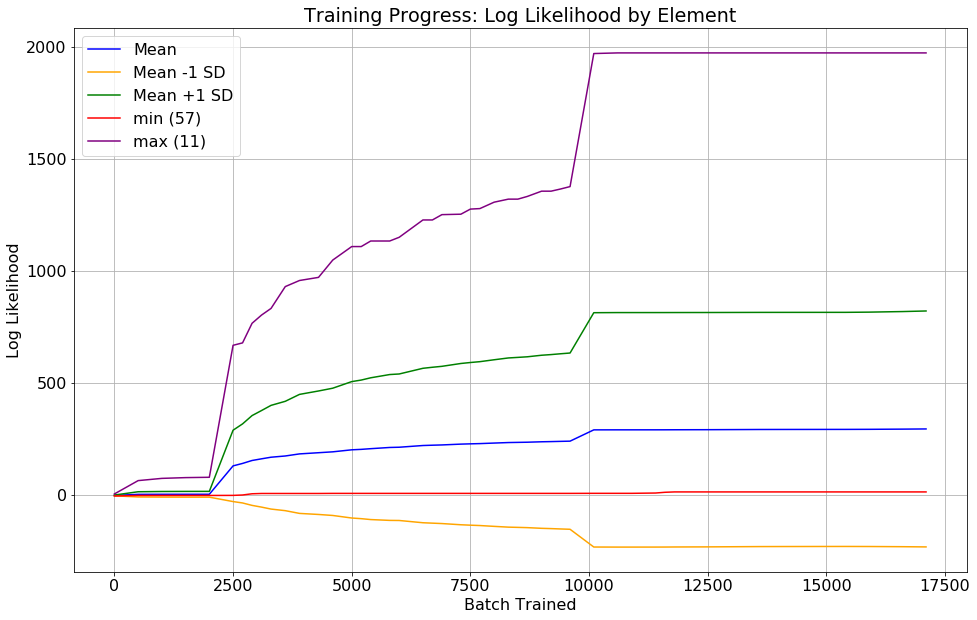

In [42]:
# Learning curve: log likelihood
fig, ax = model.plot_hist('log_like')

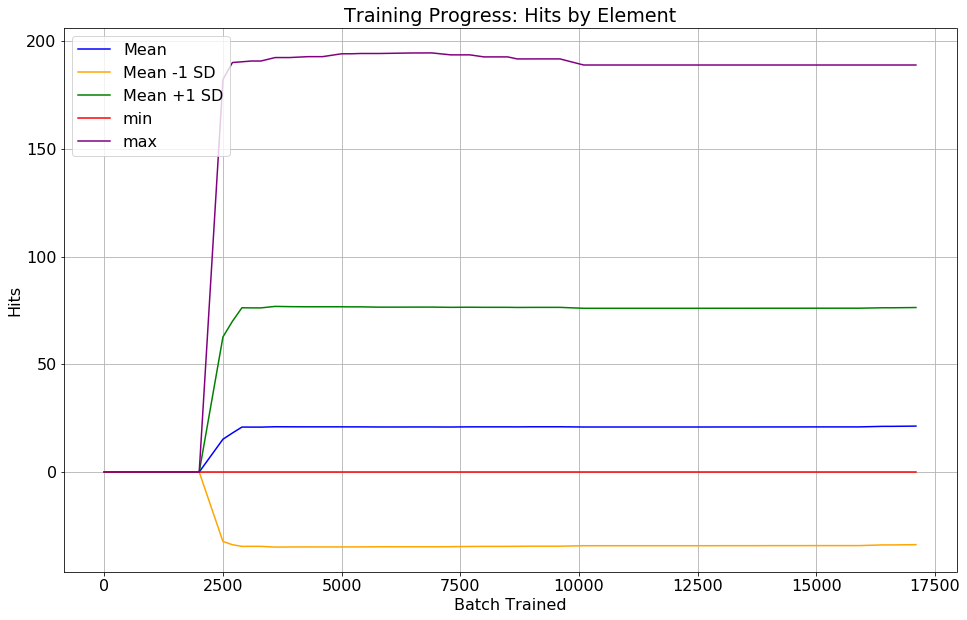

In [43]:
# Learning curve: hits
fig, ax = model.plot_hist('hits')

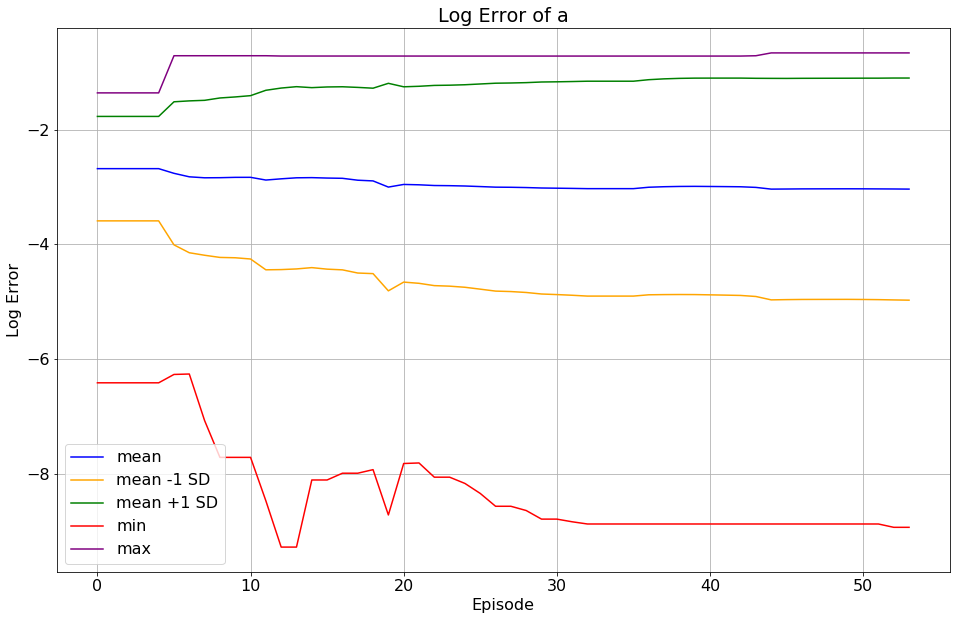

In [44]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error(elts_true=elts_ast, elt_name='a', is_log=True, elt_num=None)

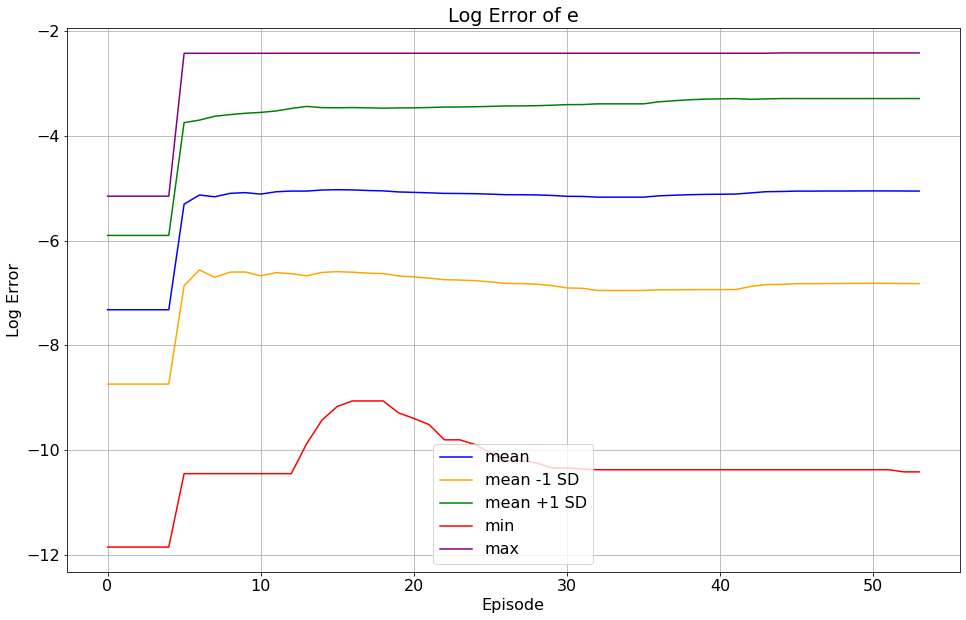

In [45]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error(elts_true=elts_ast, elt_name='e', is_log=True, elt_num=None)